In [ ]:
!pip install timm
!pip install lightning
!pip install astropy
import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


import sys
sys.path.append('/content/')

from dataloader_fits_cr import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

import scipy.stats as stats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/Dataset/aia_synoptic_copy_1.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 1024
num_epochs = 10
batch_size = 2
learning_rate = 0.001
dropout = 0.5
lstm_layers = 2

k_folds = 5

In [ ]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

In [ ]:
dataset = SunImageDataset(csv_file="/content/dataset_full_with_cr_2days.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size]
k_fold_2_indices = indices[fold_size:2*fold_size]
k_fold_3_indices = indices[2*fold_size:3*fold_size]
k_fold_4_indices = indices[3*fold_size:4*fold_size]
k_fold_5_indices = indices[4*fold_size:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]

# Get date list
kp_dates = pd.read_csv("/content/matched_kp_dates_full_with_cr_2days.csv")
kp_dates_list = kp_dates["date"].tolist()

1097
1097
1097
1097
1099


In [ ]:
# Get active indices
dataset_csv_file = pd.read_csv("/content/dataset_full_with_cr_2days.csv")
active_indices = []

for i in dataset_csv_file.index:
    if dataset_csv_file['Kp'][i] >= 3.667:
        active_indices.append(i)

active_dataloaders = []
for dataloader in dataloaders:
    active_dataloaders.append(list(set(dataloader) & set(active_indices)))

for dataloader in active_dataloaders:
    print(len(dataloader))

264
261
403
446
329


In [ ]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()

        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)

        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )

        self.lstm = nn.LSTM(hidden_size, hidden_size * 2, lstm_layers, batch_first=True)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            nn.Linear((hidden_size*2) + 2, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),

        )

    def forward(self, images, kp) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """

        batch_size = images.shape[0]

        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, 10, -1)
        # hidden_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # cell_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # image_features, _ = self.lstm(image_features, (hidden_states, cell_states))
        image_features, _ = self.lstm(image_features)
        image_features = image_features[:, -1, :]
        kp = kp.reshape(batch_size, 1)
        kp = kp.repeat(1, 2)
        image_features = torch.cat((image_features, kp), dim=1)
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 3.667:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 3.667:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1

    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):

    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if ((tp > 0 and tn > 0) or fp > 0) else 0
    return tss

def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1





In [ ]:
def train_model(fabric):
  print(fabric.device)
  total_avg_test_loss = 0
  total_rmse = 0
  total_mse = 0
  total_mae = 0
  total_r2 = 0
  total_r = 0
  total_tts = 0
  total_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0

  active_total_avg_test_loss = 0
  active_total_rmse = 0
  active_total_mse = 0
  active_total_mae = 0
  active_total_r2 = 0
  active_total_r = 0


  for i in range(k_folds):
      print(f'FOLD {i + 1}')
      print('--------------------------------')
      test_indices = dataloaders[i]
      active_test_indices = active_dataloaders[i]
      train_indices = []
      for j in range(k_folds):
          if j != i:
              train_indices += dataloaders[j]

      trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=20, prefetch_factor=6, pin_memory=True, worker_init_fn=lambda _: np.random.seed(42))
      testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      active_testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, active_test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      trainloader = fabric.setup_dataloaders(trainloader)
      testloader = fabric.setup_dataloaders(testloader)
      active_testloader = fabric.setup_dataloaders(active_testloader)


      # Reinitialize model
      model = GmiSwinTransformer(hidden_size=hidden_size)
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      model, optimizer = fabric.setup(model, optimizer)
      model.train()

      # Training the model
      n_total_steps = len(trainloader)
      avg_train_loss_over_epochs = []
      avg_val_loss_over_epochs = []

      for epoch in range(num_epochs):
          train_losses = []
          val_losses = []

          # Training loop
          model.train()
          for i, (images, labels, p_Kp) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
              # Move images and labels to device
              images = images.float()
              labels = labels.float()
              p_Kp = p_Kp.float()

              # Forward pass with autograd
              outputs = model(images, p_Kp).squeeze(1)
              loss = criterion(outputs, labels)
              # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

              # Backward pass and optimization
              optimizer.zero_grad()
              fabric.backward(loss)
              optimizer.step()
              # Store the loss
              train_losses.append(loss.item())

          # Store the average training loss for this epoch
          avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
          print("Average Training Loss: ", sum(train_losses) / len(train_losses))

          # Validation loop
          model.eval()
          with torch.no_grad():
              for images, labels, p_Kp in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                  images = images.float()
                  p_Kp = p_Kp.float()
                  # images = images.permute(1, 0, 2, 3, 4)
                  labels = labels.float()
                  outputs = model(images, p_Kp).squeeze(1)
                  loss = criterion(outputs, labels)
                  # print("Validation Loss: ", loss.item())
                  val_losses.append(loss.item())

          # Store the average validation loss for this epoch
          avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
          print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

      # Plot loss over epochs
      plt.figure()
      plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
      plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
      plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
      plt.xlabel('Epoch')
      plt.ylabel('Average Loss')
      plt.legend()
      plt.title('Training and Validation Loss Over Epochs')
      plt.show()

      test_losses = []
      all_labels = []
      all_outputs = []

      model.eval()

      print('--------------------------------')
      print('Test for Full set')
      print('--------------------------------')

  # Test for Full set
      with torch.no_grad():
          for images, labels, p_Kp in tqdm(testloader, desc="Testing Progress"):
              images = images.float()
              # images = images.permute(1, 0, 2, 3, 4)
              labels = labels.float()
              p_Kp = p_Kp.float()
              # print("Label: ", labels)
              outputs = model(images, p_Kp).squeeze(1)
              # print("Output: ", outputs)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      total_avg_test_loss += avg_test_loss
      total_rmse += rmse
      total_mse += mse
      total_mae += mae
      total_r2 += r2
      total_r += r
      total_tts += tts
      total_accuracy += accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1


      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')

      test_dates = list(kp_dates_list[i] for i in test_indices)
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
      plt.plot([0, len(test_dates)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')
      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Format x-axis with dates
      test_dates_sliced = test_dates[0:len(all_labels):20]
      plt.xticks(range(0, len(test_dates), 20), test_dates_sliced, rotation=30, ha='right')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Date', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)

      print('--------------------------------')
      print('Test for Active Periods')
      print('--------------------------------')

      test_losses = []
      all_labels = []
      all_outputs = []

  # Test for active periods
      with torch.no_grad():
          for images, labels, p_Kp in tqdm(active_testloader, desc="Testing Progress"):
              images = images.float()
              labels = labels.float()
              p_Kp = p_Kp.float()
              outputs = model(images, p_Kp).squeeze(1)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      active_total_avg_test_loss += avg_test_loss
      active_total_rmse += rmse
      active_total_mse += mse
      active_total_mae += mae
      active_total_r2 += r2
      active_total_r += r




      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with a window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')

      plt.plot([0, len(all_labels)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')

      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Sample Index', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)


  print('--------------------------------')
  print('Metrics for Full Set')
  print('--------------------------------')

  # Average metrics across all folds
  total_avg_test_loss /= k_folds
  total_rmse /= k_folds
  total_mse /= k_folds
  total_mae /= k_folds
  total_r2 /= k_folds
  total_r /= k_folds
  total_tts /= k_folds
  total_accuracy /= k_folds
  total_precision /= k_folds
  total_recall /= k_folds
  total_f1 /= k_folds

  print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
  print(f'Average RMSE across all folds: {total_rmse:.4f}')
  print(f'Average MSE across all folds: {total_mse:.4f}')
  print(f'Average MAE across all folds: {total_mae:.4f}')
  print(f'Average R² across all folds: {total_r2:.4f}')
  print(f'Average R across all folds: {total_r:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')
  print(f'Average True Skill Score across all folds: {total_tts:.4f}')
  print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
  print(f'Average Precision across all folds: {total_precision:.4f}')
  print(f'Average Recall across all folds: {total_recall:.4f}')
  print(f'Average F1 Score across all folds: {total_f1:.4f}')

  print('--------------------------------')
  print('Metrics for Active Periods')
  print('--------------------------------')
  # Average metrics across all folds
  active_total_avg_test_loss /= k_folds
  active_total_rmse /= k_folds
  active_total_mse /= k_folds
  active_total_mae /= k_folds
  active_total_r2 /= k_folds
  active_total_r /= k_folds

  print(f'Average active test loss across all folds: {active_total_avg_test_loss:.4f}')
  print(f'Average active RMSE across all folds: {active_total_rmse:.4f}')
  print(f'Average active MSE across all folds: {active_total_mse:.4f}')
  print(f'Average active MAE across all folds: {active_total_mae:.4f}')
  print(f'Average active R² across all folds: {active_total_r2:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')




INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0
FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.322717842942789


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6352704145795596


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.513138917741893


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.860466325609684


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.1726004563577623


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7787954188923303


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.9003444140824327


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.402101147254163


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7203888362966762


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1316999350690486


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6000659733371605


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.044543431350412


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5205610610826595


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2848357999920403


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4677237753546328


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0085843267871


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4051298493519293


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2958561252282665


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.36271917823874


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0911804862203374


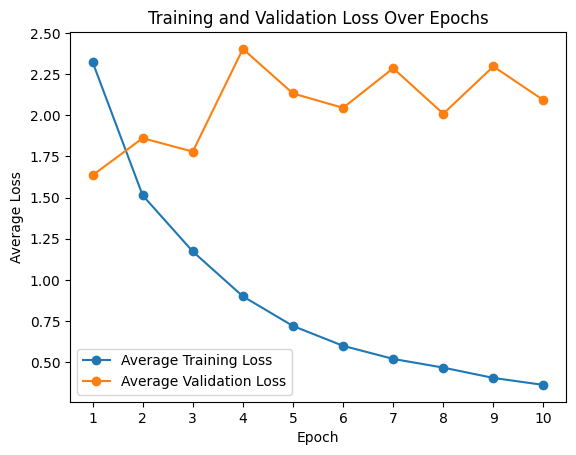

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.0912
RMSE: 1.4461
MSE: 2.0930
MAE: 1.0722
R²: -0.1552
R: 0.2880
True Skill Score: 0.3344
Accuracy: 0.7511
Precision: 0.4809
Recall: 0.4280
F1 Score: 0.4529


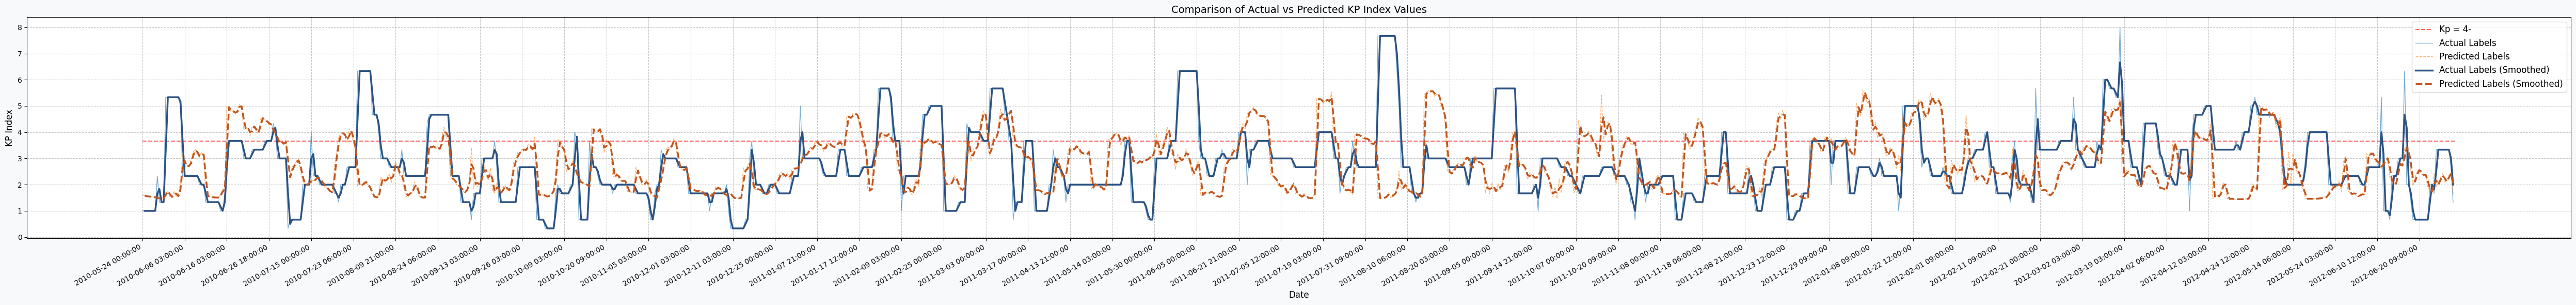

[np.float32(1.609375), np.float32(1.5625), np.float32(1.5546875), np.float32(1.546875), np.float32(1.53125), np.float32(1.5234375), np.float32(1.5234375), np.float32(1.46875), np.float32(1.484375), np.float32(1.4921875), np.float32(1.484375), np.float32(1.71875), np.float32(1.75), np.float32(1.53125), np.float32(1.53125), np.float32(1.7578125), np.float32(1.5625), np.float32(1.5625), np.float32(2.109375), np.float32(3.15625), np.float32(2.671875), np.float32(2.75), np.float32(2.671875), np.float32(2.953125), np.float32(3.234375), np.float32(3.359375), np.float32(3.140625), np.float32(3.046875), np.float32(3.25), np.float32(3.046875), np.float32(1.5859375), np.float32(1.546875), np.float32(1.53125), np.float32(1.5234375), np.float32(1.5078125), np.float32(1.5078125), np.float32(1.515625), np.float32(1.640625), np.float32(1.8203125), np.float32(1.8203125), np.float32(5.0), np.float32(4.90625), np.float32(4.78125), np.float32(4.8125), np.float32(4.6875), np.float32(4.875), np.float32(5.06

Testing Progress:   0%|          | 0/132 [00:00<?, ?it/s]

Average test loss: 4.7369
RMSE: 2.1764
MSE: 4.7369
MAE: 1.6568
R²: -3.3616
R: -0.2231
True Skill Score: 0.0000
Accuracy: 0.4280
Precision: 1.0000
Recall: 0.4280
F1 Score: 0.5995


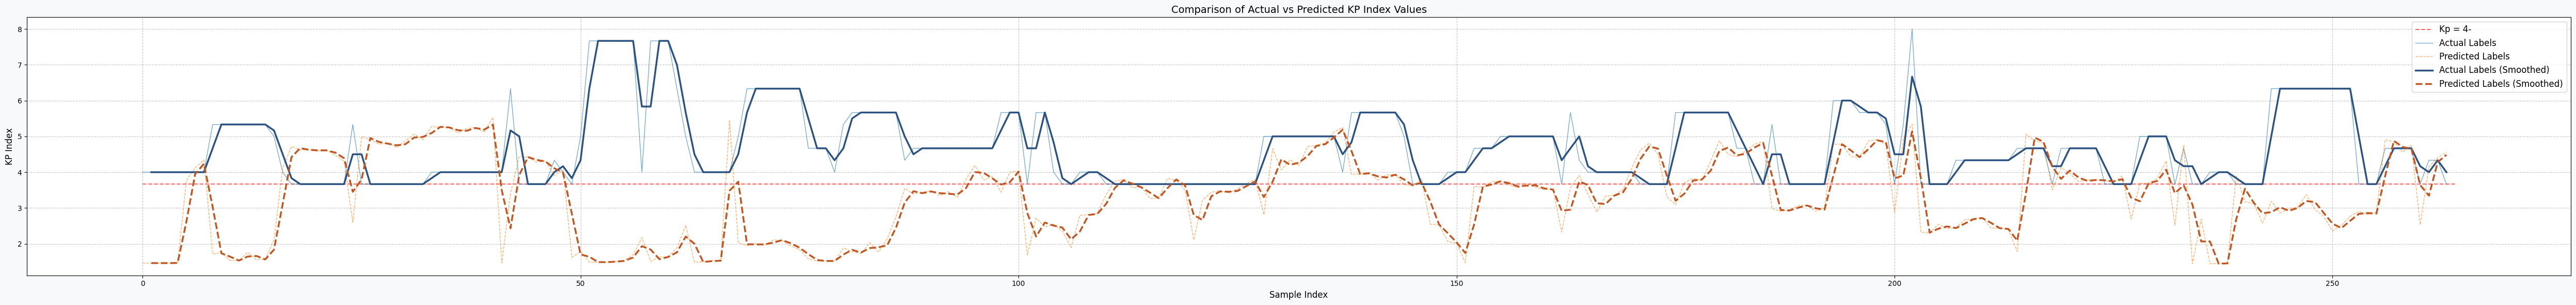

[np.float32(1.4609375), np.float32(1.4609375), np.float32(1.4609375), np.float32(1.4609375), np.float32(1.46875), np.float32(3.765625), np.float32(4.125), np.float32(4.34375), np.float32(1.71875), np.float32(1.75), np.float32(1.53125), np.float32(1.53125), np.float32(1.7578125), np.float32(1.5625), np.float32(1.5625), np.float32(2.109375), np.float32(4.125), np.float32(4.71875), np.float32(4.625), np.float32(4.625), np.float32(4.59375), np.float32(4.625), np.float32(4.46875), np.float32(4.3125), np.float32(2.59375), np.float32(5.0), np.float32(4.90625), np.float32(4.78125), np.float32(4.8125), np.float32(4.6875), np.float32(4.875), np.float32(5.0625), np.float32(4.90625), np.float32(5.28125), np.float32(5.25), np.float32(5.25), np.float32(5.09375), np.float32(5.21875), np.float32(5.25), np.float32(5.125), np.float32(5.53125), np.float32(1.4609375), np.float32(3.40625), np.float32(4.4375), np.float32(4.40625), np.float32(4.28125), np.float32(4.3125), np.float32(3.90625), np.float32(4.06

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.269575888184716


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.3682359057230085


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.403390950228871


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.566298365599636


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.06166517517266


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.8056849357633866


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.8113457124191018


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.9625129970538056


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6689897646773489


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.750280879287156


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5571217923416917


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.4124494619658625


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4694232623281392


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.173260759285423


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.41349220459253094


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.4669950491842476


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3598679588969075


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.5933172088616843


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.33770380151428386


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.5880507347971298


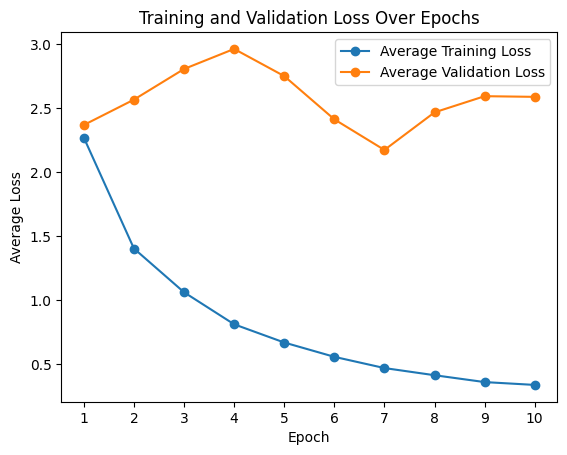

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.5881
RMSE: 1.6087
MSE: 2.5904
MAE: 1.3314
R²: -0.3207
R: 0.1473
True Skill Score: 0.0853
Accuracy: 0.6682
Precision: 0.3042
Recall: 0.3065
F1 Score: 0.3053


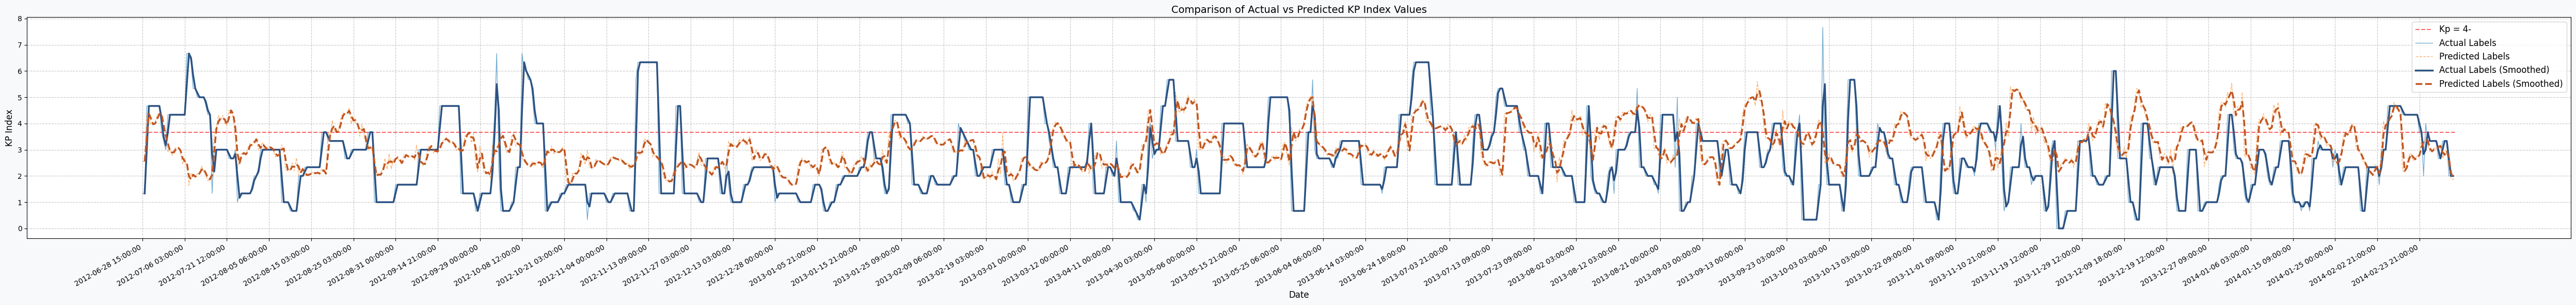

[np.float32(2.546875), np.float32(2.5625), np.float32(4.34375), np.float32(4.40625), np.float32(3.96875), np.float32(3.96875), np.float32(4.03125), np.float32(4.34375), np.float32(4.375), np.float32(4.375), np.float32(3.5), np.float32(3.578125), np.float32(2.90625), np.float32(3.0), np.float32(2.78125), np.float32(3.03125), np.float32(3.09375), np.float32(3.046875), np.float32(2.90625), np.float32(2.453125), np.float32(2.671875), np.float32(2.34375), np.float32(1.640625), np.float32(2.109375), np.float32(1.9921875), np.float32(1.953125), np.float32(2.09375), np.float32(2.09375), np.float32(2.375), np.float32(2.171875), np.float32(2.03125), np.float32(1.8125), np.float32(1.9296875), np.float32(2.15625), np.float32(3.734375), np.float32(3.828125), np.float32(4.3125), np.float32(4.09375), np.float32(4.3125), np.float32(4.0), np.float32(3.921875), np.float32(4.5), np.float32(4.5), np.float32(4.21875), np.float32(3.46875), np.float32(2.28125), np.float32(2.6875), np.float32(2.859375), np.fl

Testing Progress:   0%|          | 0/131 [00:00<?, ?it/s]

Average test loss: 3.2415
RMSE: 1.8004
MSE: 3.2536
MAE: 1.5128
R²: -3.8080
R: -0.0551
True Skill Score: 0.0000
Accuracy: 0.3065
Precision: 1.0000
Recall: 0.3065
F1 Score: 0.4692


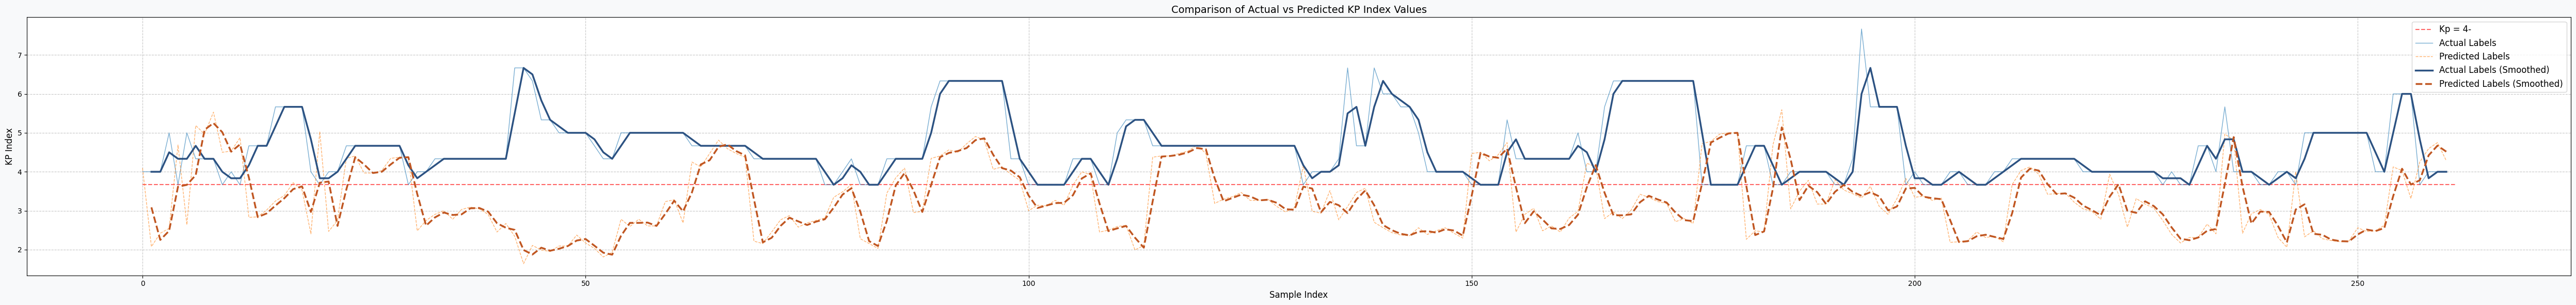

[np.float32(4.09375), np.float32(2.078125), np.float32(2.421875), np.float32(2.546875), np.float32(4.6875), np.float32(2.640625), np.float32(5.1875), np.float32(4.96875), np.float32(5.53125), np.float32(4.5), np.float32(4.53125), np.float32(4.875), np.float32(2.828125), np.float32(2.84375), np.float32(3.015625), np.float32(3.25), np.float32(3.390625), np.float32(3.71875), np.float32(3.53125), np.float32(2.40625), np.float32(5.03125), np.float32(2.46875), np.float32(2.75), np.float32(4.34375), np.float32(4.40625), np.float32(3.96875), np.float32(3.96875), np.float32(4.03125), np.float32(4.34375), np.float32(4.375), np.float32(4.375), np.float32(2.484375), np.float32(2.75), np.float32(2.90625), np.float32(3.0), np.float32(2.78125), np.float32(3.03125), np.float32(3.09375), np.float32(3.046875), np.float32(2.90625), np.float32(2.453125), np.float32(2.671875), np.float32(2.34375), np.float32(1.640625), np.float32(2.109375), np.float32(1.9921875), np.float32(1.953125), np.float32(2.09375), 

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.2418996785787795


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.764551159686792


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.4611095131680685


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0079872649517556


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.1199350008991884


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9596259256431288


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.8439203988351665


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.273341651137355


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6920670725755655


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1004380233386932


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5738629450095534


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.168659243873704


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.48680924900451034


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.185800083558786


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4180911026267126


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.05182053268438


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.33698005346705445


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2808504740935316


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3279387981752846


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1037894791833556


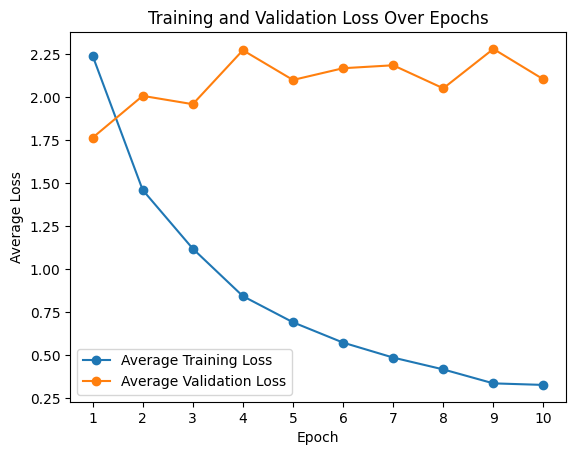

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.1038
RMSE: 1.4504
MSE: 2.1047
MAE: 1.1403
R²: -0.1156
R: 0.3019
True Skill Score: 0.5674
Accuracy: 0.6691
Precision: 0.6408
Recall: 0.2258
F1 Score: 0.3339


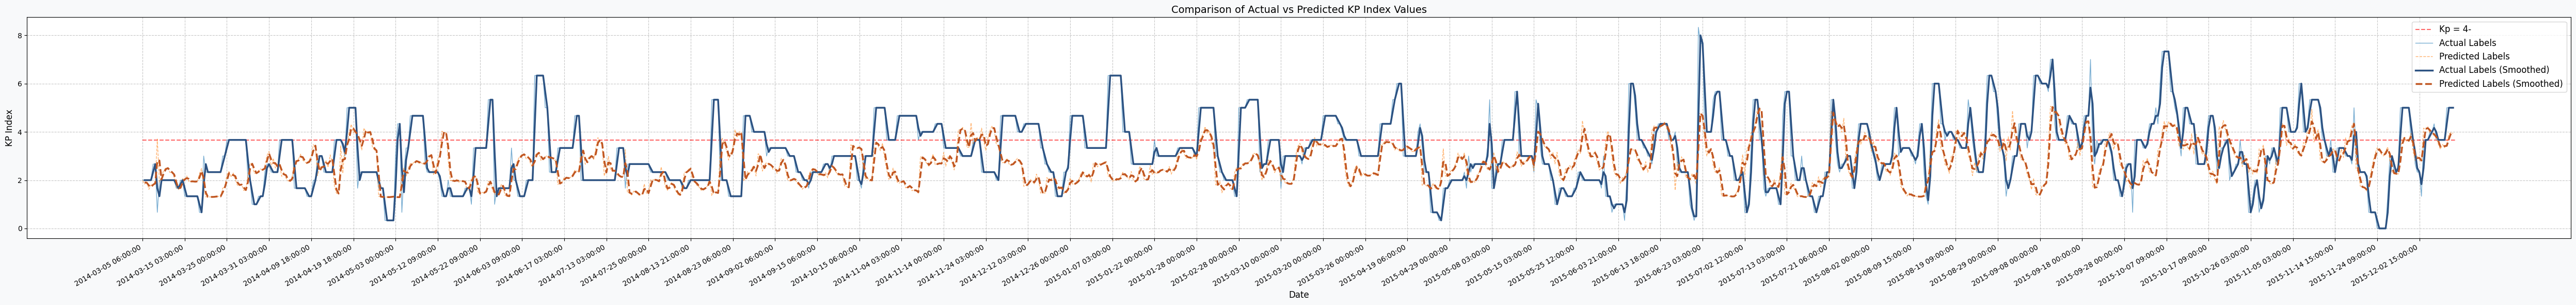

[np.float32(1.984375), np.float32(1.8359375), np.float32(1.9453125), np.float32(1.6171875), np.float32(1.8046875), np.float32(1.8125), np.float32(1.9140625), np.float32(3.703125), np.float32(1.921875), np.float32(2.140625), np.float32(2.40625), np.float32(2.5), np.float32(2.5), np.float32(2.3125), np.float32(2.34375), np.float32(2.125), np.float32(1.71875), np.float32(1.609375), np.float32(1.75), np.float32(2.0625), np.float32(2.0), np.float32(2.171875), np.float32(1.9296875), np.float32(1.96875), np.float32(1.9296875), np.float32(1.9453125), np.float32(1.953125), np.float32(2.265625), np.float32(2.484375), np.float32(1.6640625), np.float32(1.3046875), np.float32(1.3125), np.float32(1.3046875), np.float32(1.3046875), np.float32(1.3125), np.float32(1.328125), np.float32(1.328125), np.float32(1.3203125), np.float32(1.6640625), np.float32(1.7265625), np.float32(2.21875), np.float32(2.359375), np.float32(2.125), np.float32(2.296875), np.float32(2.03125), np.float32(1.7890625), np.float32(1

Testing Progress:   0%|          | 0/202 [00:00<?, ?it/s]

Average test loss: 3.8806
RMSE: 1.9699
MSE: 3.8874
MAE: 1.6619
R²: -3.8778
R: 0.1762
True Skill Score: 0.0000
Accuracy: 0.2258
Precision: 1.0000
Recall: 0.2258
F1 Score: 0.3684


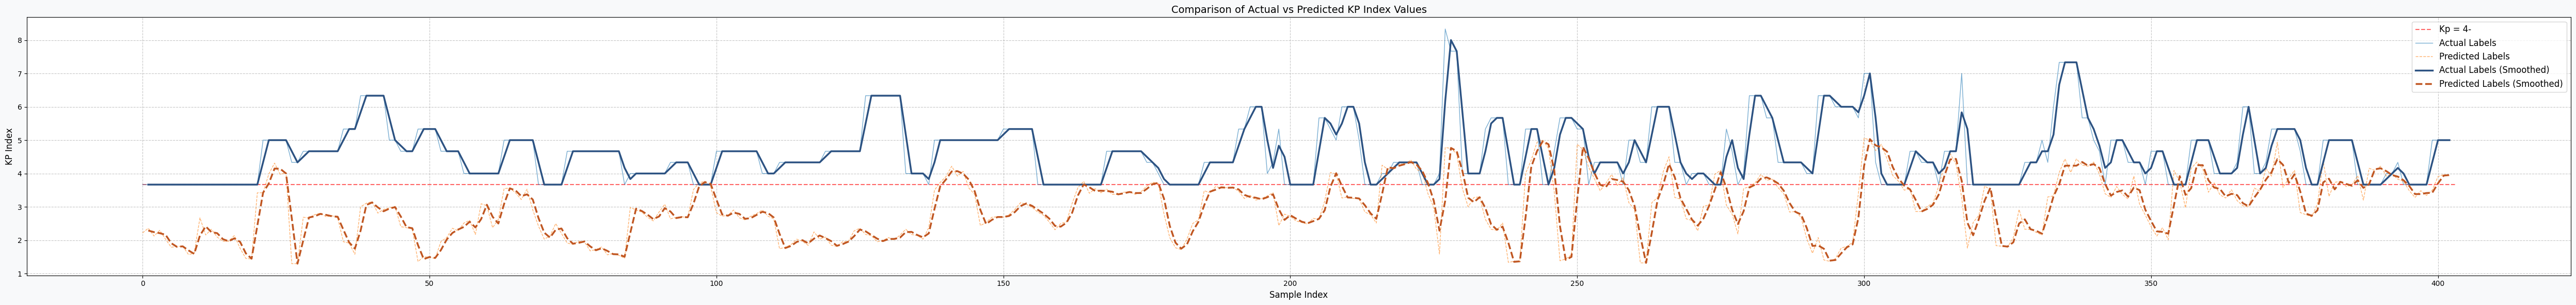

[np.float32(2.21875), np.float32(2.359375), np.float32(2.125), np.float32(2.296875), np.float32(2.03125), np.float32(1.7890625), np.float32(1.8125), np.float32(1.8203125), np.float32(1.5703125), np.float32(1.609375), np.float32(2.671875), np.float32(2.15625), np.float32(2.328125), np.float32(2.09375), np.float32(1.96875), np.float32(1.96875), np.float32(2.140625), np.float32(1.7578125), np.float32(1.453125), np.float32(1.4375), np.float32(3.421875), np.float32(3.421875), np.float32(3.984375), np.float32(4.3125), np.float32(3.96875), np.float32(4.03125), np.float32(1.296875), np.float32(1.296875), np.float32(2.6875), np.float32(2.671875), np.float32(2.765625), np.float32(2.8125), np.float32(2.703125), np.float32(2.734375), np.float32(2.671875), np.float32(1.953125), np.float32(1.9140625), np.float32(1.578125), np.float32(3.0), np.float32(3.109375), np.float32(3.15625), np.float32(2.8125), np.float32(2.921875), np.float32(2.96875), np.float32(3.015625), np.float32(2.40625), np.float32(2.

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.322274259877763


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.316985613953166


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.7016377773852027


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7303445171643541


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.3322117247076701


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.4550543817812995


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.0204755098815659


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.5982322632014003


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.8046769947507567


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6742710347046892


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6716491182953658


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.5347335097358419


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5370321799942626


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.623945491767161


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4628370974114237


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.510149810284008


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4066435556184832


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7947468851698911


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.34378378468878623


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.4588576538720675


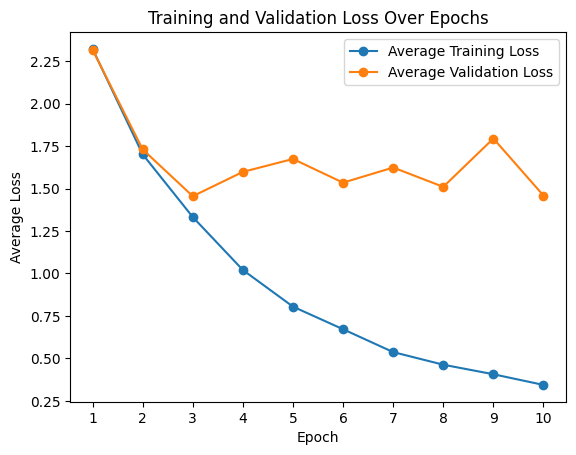

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.4589
RMSE: 1.2078
MSE: 1.4601
MAE: 0.9636
R²: 0.2041
R: 0.4874
True Skill Score: 0.4916
Accuracy: 0.6974
Precision: 0.6667
Recall: 0.5112
F1 Score: 0.5787


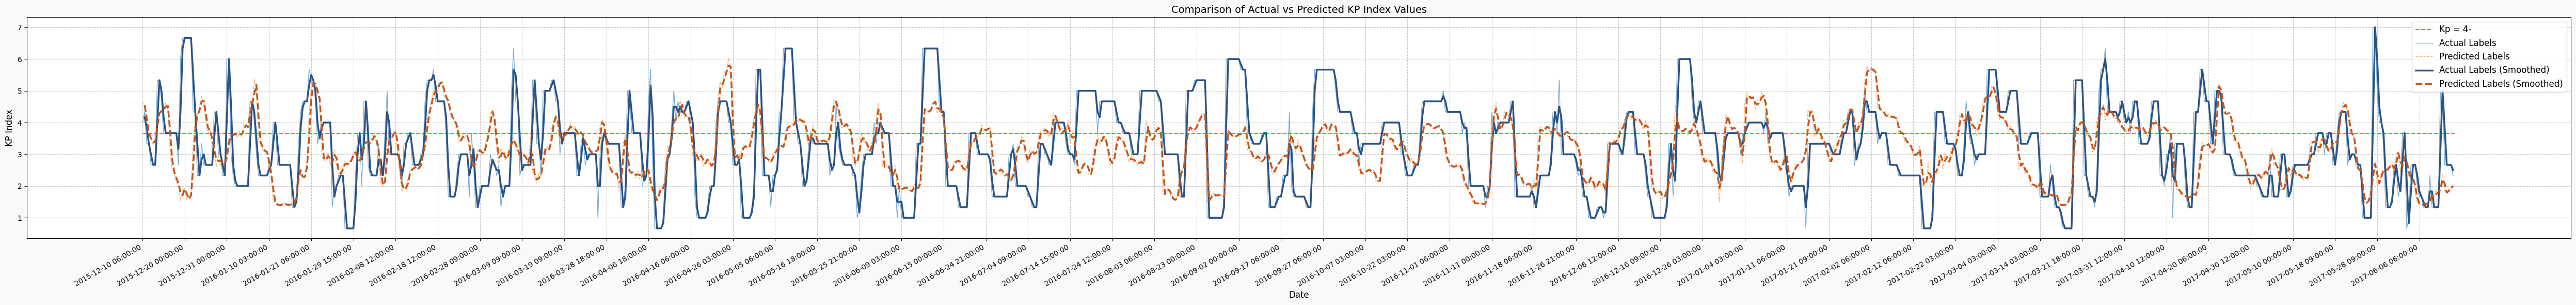

[np.float32(4.65625), np.float32(4.4375), np.float32(3.828125), np.float32(3.515625), np.float32(3.484375), np.float32(3.296875), np.float32(3.46875), np.float32(4.28125), np.float32(4.3125), np.float32(4.40625), np.float32(4.375), np.float32(4.625), np.float32(4.40625), np.float32(3.21875), np.float32(2.484375), np.float32(2.421875), np.float32(2.109375), np.float32(2.046875), np.float32(1.546875), np.float32(1.875), np.float32(1.9375), np.float32(1.578125), np.float32(1.6015625), np.float32(1.8125), np.float32(3.34375), np.float32(4.1875), np.float32(4.25), np.float32(4.5), np.float32(4.8125), np.float32(4.5625), np.float32(4.03125), np.float32(3.65625), np.float32(3.8125), np.float32(3.21875), np.float32(3.078125), np.float32(2.609375), np.float32(2.96875), np.float32(2.625), np.float32(2.796875), np.float32(2.609375), np.float32(3.1875), np.float32(3.578125), np.float32(3.59375), np.float32(3.609375), np.float32(3.6875), np.float32(3.515625), np.float32(3.71875), np.float32(3.54687

Testing Progress:   0%|          | 0/223 [00:00<?, ?it/s]

Average test loss: 2.0970
RMSE: 1.4481
MSE: 2.0970
MAE: 1.1380
R²: -2.3030
R: 0.1123
True Skill Score: 0.0000
Accuracy: 0.5112
Precision: 1.0000
Recall: 0.5112
F1 Score: 0.6766


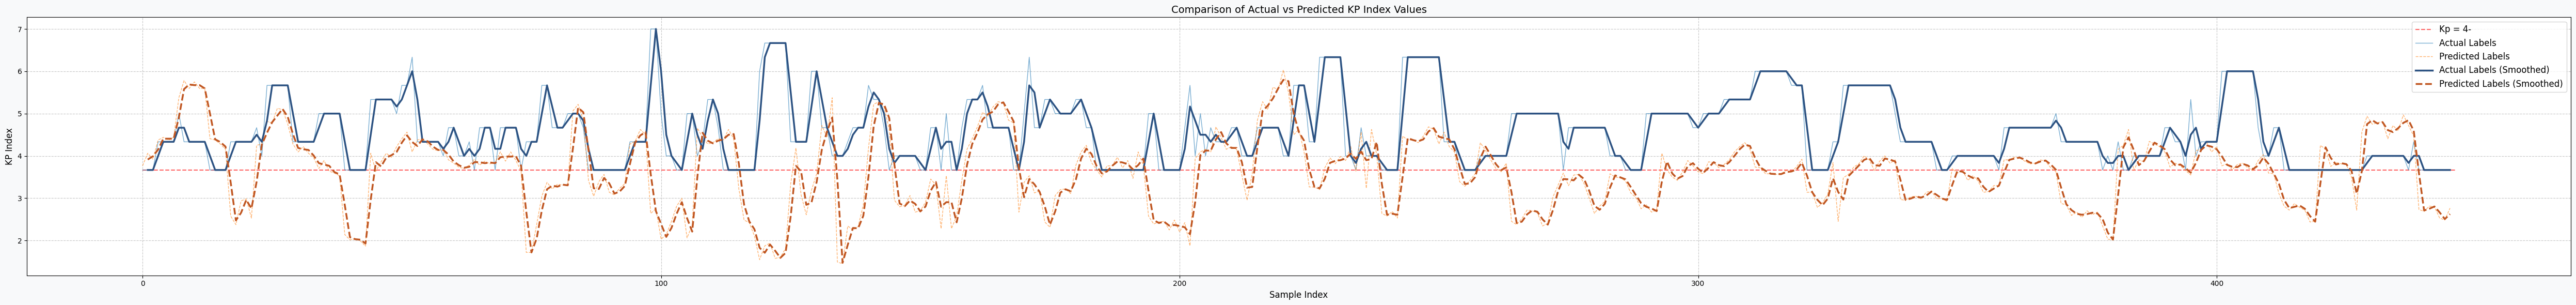

[np.float32(3.765625), np.float32(4.0625), np.float32(3.921875), np.float32(4.375), np.float32(4.4375), np.float32(4.375), np.float32(4.4375), np.float32(5.375), np.float32(5.78125), np.float32(5.59375), np.float32(5.75), np.float32(5.59375), np.float32(5.59375), np.float32(4.40625), np.float32(4.375), np.float32(4.28125), np.float32(4.15625), np.float32(2.578125), np.float32(2.375), np.float32(2.9375), np.float32(2.984375), np.float32(2.53125), np.float32(4.25), np.float32(4.28125), np.float32(4.8125), np.float32(4.78125), np.float32(5.125), np.float32(5.09375), np.float32(4.75), np.float32(4.28125), np.float32(4.09375), np.float32(4.21875), np.float32(4.0625), np.float32(3.953125), np.float32(3.703125), np.float32(3.890625), np.float32(3.640625), np.float32(3.59375), np.float32(3.53125), np.float32(2.140625), np.float32(2.015625), np.float32(2.046875), np.float32(1.9921875), np.float32(1.8671875), np.float32(4.0625), np.float32(3.640625), np.float32(3.859375), np.float32(4.0625), np.

Training Progress: Epoch: 1:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  2.3301067707000573


Validation Progress: Epoch: 1:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.3549219735050495


Training Progress: Epoch: 2:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.6136328524114745


Validation Progress: Epoch: 2:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.4152480114333925


Training Progress: Epoch: 3:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.2862857262365006


Validation Progress: Epoch: 3:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.4654343130920262


Training Progress: Epoch: 4:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.0306206401271971


Validation Progress: Epoch: 4:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.821272721692962


Training Progress: Epoch: 5:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.814739165806978


Validation Progress: Epoch: 5:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.601981893259905


Training Progress: Epoch: 6:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.657423471386082


Validation Progress: Epoch: 6:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.383246141502803


Training Progress: Epoch: 7:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.5342733630258373


Validation Progress: Epoch: 7:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.4372325727039954


Training Progress: Epoch: 8:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.4760730407403207


Validation Progress: Epoch: 8:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.3255824554913918


Training Progress: Epoch: 9:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.394086737826306


Validation Progress: Epoch: 9:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.490498801330865


Training Progress: Epoch: 10:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.35709655316039207


Validation Progress: Epoch: 10:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5237608233830806


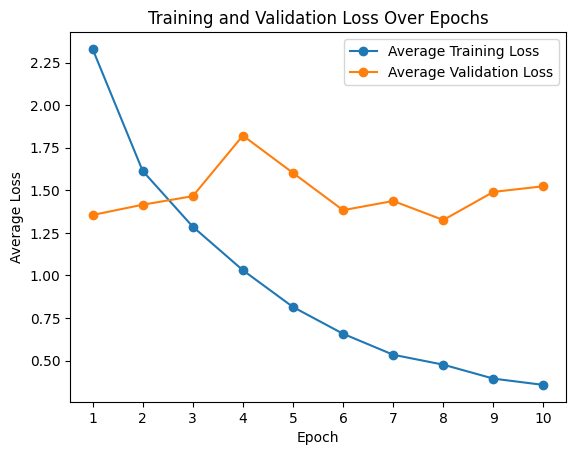

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/550 [00:00<?, ?it/s]

Average test loss: 1.5238
RMSE: 1.2344
MSE: 1.5249
MAE: 0.9815
R²: 0.1350
R: 0.4618
True Skill Score: 0.4420
Accuracy: 0.7416
Precision: 0.5849
Recall: 0.4711
F1 Score: 0.5219


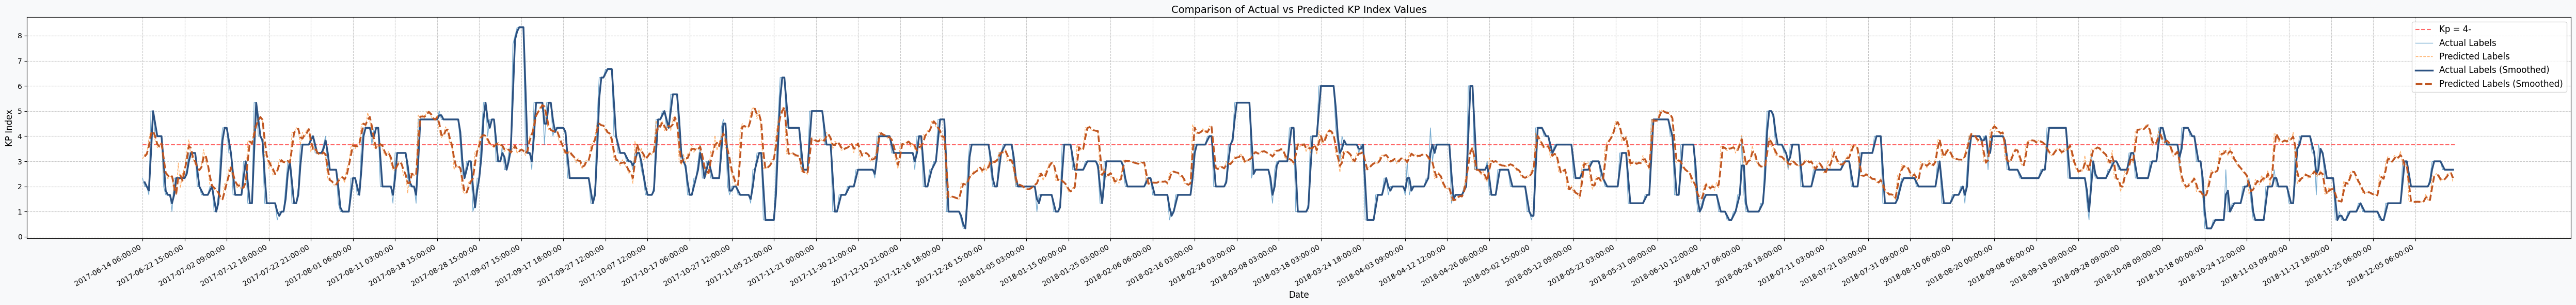

[np.float32(3.09375), np.float32(3.28125), np.float32(3.296875), np.float32(3.90625), np.float32(4.25), np.float32(4.15625), np.float32(3.828125), np.float32(3.546875), np.float32(3.625), np.float32(3.796875), np.float32(2.515625), np.float32(2.578125), np.float32(2.3125), np.float32(2.390625), np.float32(2.421875), np.float32(1.59375), np.float32(1.828125), np.float32(2.9375), np.float32(1.9453125), np.float32(2.515625), np.float32(2.75), np.float32(3.359375), np.float32(3.859375), np.float32(3.1875), np.float32(3.09375), np.float32(2.890625), np.float32(2.625), np.float32(2.671875), np.float32(2.859375), np.float32(3.46875), np.float32(3.0), np.float32(2.78125), np.float32(2.046875), np.float32(2.015625), np.float32(1.890625), np.float32(1.8515625), np.float32(1.6796875), np.float32(1.4921875), np.float32(1.484375), np.float32(2.109375), np.float32(2.15625), np.float32(2.703125), np.float32(2.796875), np.float32(2.21875), np.float32(2.203125), np.float32(1.9296875), np.float32(2.1093

Testing Progress:   0%|          | 0/165 [00:00<?, ?it/s]

Average test loss: 1.5952
RMSE: 1.2630
MSE: 1.5957
MAE: 0.9451
R²: -1.0649
R: 0.3513
True Skill Score: 0.0000
Accuracy: 0.4711
Precision: 1.0000
Recall: 0.4711
F1 Score: 0.6405


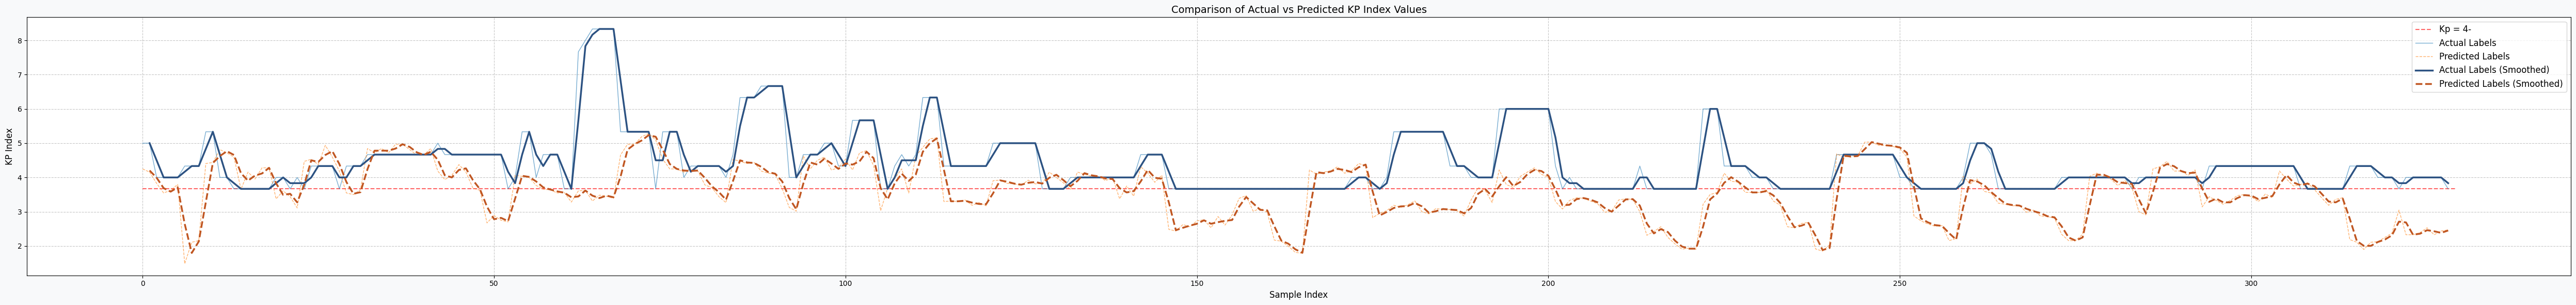

[np.float32(4.25), np.float32(4.15625), np.float32(3.828125), np.float32(3.546875), np.float32(3.625), np.float32(3.796875), np.float32(1.484375), np.float32(2.109375), np.float32(2.15625), np.float32(4.40625), np.float32(4.4375), np.float32(4.8125), np.float32(4.71875), np.float32(4.59375), np.float32(3.65625), np.float32(4.15625), np.float32(3.953125), np.float32(4.28125), np.float32(4.28125), np.float32(3.375), np.float32(3.609375), np.float32(3.4375), np.float32(3.109375), np.float32(4.46875), np.float32(4.53125), np.float32(4.375), np.float32(4.9375), np.float32(4.59375), np.float32(4.1875), np.float32(3.546875), np.float32(3.5), np.float32(3.640625), np.float32(4.84375), np.float32(4.71875), np.float32(4.84375), np.float32(4.71875), np.float32(4.96875), np.float32(4.96875), np.float32(4.8125), np.float32(4.65625), np.float32(4.65625), np.float32(4.84375), np.float32(4.1875), np.float32(3.9375), np.float32(4.0625), np.float32(4.375), np.float32(4.15625), np.float32(3.6875), np.flo

In [ ]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch(train_model)


In [ ]:
# prompt: disconnect runtime
import time
time.sleep(5 * 60)
from google.colab import runtime
runtime.unassign()
